# Parallel Node Execution

A volte il nostro grafo non segue un semplice flusso lineare che parte dallo start node e aggiunge nodi in sequenza uno dopo l'altro.

Potremmo incotrare casi dove molteplici nodi come append node A, append node B, e append node C. Tutti scritti allo stesso stato condiviso (figli di un unico nodo) e che passano i loro outputs ad un singolo nodo come una combinazione.

![alt text](parallel.png)

Questo design consente il parallel processing (esecuzione in parallelo dei tre nodi) prima di mergiare i risultati dentro uno step unificato.


In [1]:
import operator 
from typing import TypedDict, Annotated, Any

from langgraph.graph import StateGraph, START, END 

class InputState(TypedDict):
    string_value: str
    # string_value: Annotated[str, operator.add]

In [2]:
def append_a(state: InputState) -> Any:
    print(f"append_a: Current string_value='{state['string_value']}'")
    state["string_value"] += "a"
    return state

def append_b(state: InputState) -> Any:
    print(f"append_b: Current string_value='{state['string_value']}'")
    state["string_value"] += "b"
    return state

def append_c(state: InputState) -> Any:
    print(f"append_c: Current string_value='{state['string_value']}'")
    state['string_value'] += "c"
    return state

def combine_strings(state: InputState) -> Any:
    combined_string = state['string_value']

    print(f"combine_strings: Combined string_value='{combined_string}'")

    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    state['string_value'] = final_string
    return state

In [3]:
builder = StateGraph(InputState)

builder.add_node("start_node", lambda state: state)
builder.add_node("append_a_node", append_a)
builder.add_node("append_b_node", append_b)
builder.add_node("append_c_node", append_c)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")

builder.add_edge("start_node", "append_a_node")
builder.add_edge("start_node", "append_b_node")
builder.add_edge("start_node", "append_c_node")

builder.add_edge("append_a_node", "combine_node")
builder.add_edge("append_b_node", "combine_node")
builder.add_edge("append_c_node", "combine_node")

builder.add_edge("combine_node", END)

graph = builder.compile()

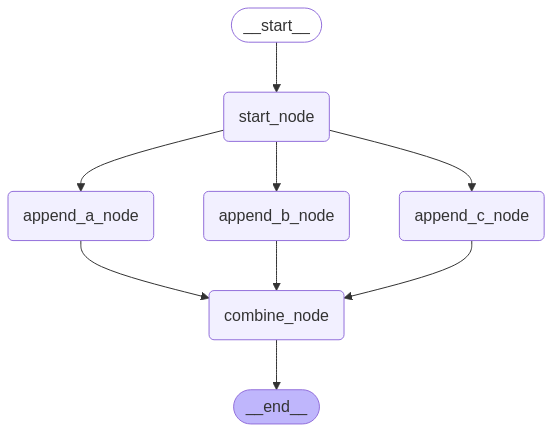

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# vediamo cosa accade se eseguiamo tale grafo
initial_state = {"string_value": ""}
result = graph.invoke(initial_state)
print(result)

append_a: Current string_value=''append_b: Current string_value=''

append_c: Current string_value=''


InvalidUpdateError: At key 'string_value': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

Vediamo che l'errore ci dice che:

At key 'string_value': Can receive only one value per step. Use an Annotated key to handle multiple values.

Quinndi, quando eseguimo un workflow parallelo dobbiamo utilizzare Annotated. Quindi dobbiamo utilizzare una reducer function (operator.add)

In [6]:
import operator 
from typing import TypedDict, Annotated, Any

from langgraph.graph import StateGraph, START, END 

class InputState(TypedDict):
    # string_value: str
    string_value: Annotated[str, operator.add]


def append_a(state: InputState) -> Any:
    print(f"append_a: Current string_value='{state['string_value']}'")
    state["string_value"] += "a"
    return state

def append_b(state: InputState) -> Any:
    print(f"append_b: Current string_value='{state['string_value']}'")
    state["string_value"] += "b"
    return state

def append_c(state: InputState) -> Any:
    print(f"append_c: Current string_value='{state['string_value']}'")
    state['string_value'] += "c"
    return state

def combine_strings(state: InputState) -> Any:
    combined_string = state['string_value']

    print(f"combine_strings: Combined string_value='{combined_string}'")

    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    state['string_value'] = final_string
    return state

builder = StateGraph(InputState)

builder.add_node("start_node", lambda state: state)
builder.add_node("append_a_node", append_a)
builder.add_node("append_b_node", append_b)
builder.add_node("append_c_node", append_c)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")

builder.add_edge("start_node", "append_a_node")
builder.add_edge("start_node", "append_b_node")
builder.add_edge("start_node", "append_c_node")

builder.add_edge("append_a_node", "combine_node")
builder.add_edge("append_b_node", "combine_node")
builder.add_edge("append_c_node", "combine_node")

builder.add_edge("combine_node", END)

graph = builder.compile()

In [7]:
initial_state = {"string_value": ""}
result = graph.invoke(initial_state)
print(result)

append_a: Current string_value=''
append_b: Current string_value=''
append_c: Current string_value=''
combine_strings: Combined string_value='abc'
combine_strings: Final string_value='ABC'
{'string_value': 'abcABC'}


Ora, se l'ordine di esecuzione è importante allora questo parallelismo non è adatto.

Possiamo usare il parallel processing se l'ordine di esecuzione non è importante, dato che l'ordine di esecuzione dipende dal nome dei nodi (nel caso di esecuzione parallela).

Dunque se cambiamo il nome di append_a_node in append_x_node allora vedremo che l'ordine e sbagliato dato che append_x_node che aggiunge la lettera "a" viene eseguito per ultimo.


In [9]:
import operator 
from typing import TypedDict, Annotated, Any

from langgraph.graph import StateGraph, START, END 

class InputState(TypedDict):
    # string_value: str
    string_value: Annotated[str, operator.add]


def append_a(state: InputState) -> Any:
    print(f"append_a: Current string_value='{state['string_value']}'")
    state["string_value"] += "a"
    return state

def append_b(state: InputState) -> Any:
    print(f"append_b: Current string_value='{state['string_value']}'")
    state["string_value"] += "b"
    return state

def append_c(state: InputState) -> Any:
    print(f"append_c: Current string_value='{state['string_value']}'")
    state['string_value'] += "c"
    return state

def combine_strings(state: InputState) -> Any:
    combined_string = state['string_value']

    print(f"combine_strings: Combined string_value='{combined_string}'")

    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    state['string_value'] = final_string
    return state

builder = StateGraph(InputState)

builder.add_node("start_node", lambda state: state)
builder.add_node("append_x_node", append_a)
builder.add_node("append_b_node", append_b)
builder.add_node("append_c_node", append_c)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")

builder.add_edge("start_node", "append_x_node")
builder.add_edge("start_node", "append_b_node")
builder.add_edge("start_node", "append_c_node")

builder.add_edge("append_x_node", "combine_node")
builder.add_edge("append_b_node", "combine_node")
builder.add_edge("append_c_node", "combine_node")

builder.add_edge("combine_node", END)

graph = builder.compile()

initial_state = {"string_value": ""}
result = graph.invoke(initial_state)
print(result)

append_a: Current string_value=''
append_b: Current string_value=''
append_c: Current string_value=''
combine_strings: Combined string_value='bca'
combine_strings: Final string_value='BCA'
{'string_value': 'bcaBCA'}


# Mapreduce with Send API

La maggior parte delle volte lavoriamo con una lista e vogliamo che faccia l'esecuzione parallela, non sappiamo l'ordine di esecuzione in anticipo.

Come dovemmo gestire questo?

LangGraph ha una Send API per rendere la funzionalità MapReduce disponibile.


In [ ]:
import operator
import random 
from typing import Any, Annotated, List, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display

class State(TypedDict):
    string_value: Annotated[str, operator.add]
    letters: List[str]


def generate_letters(_: State) -> Any:
    num_nodes = random.randint(5, 10)
    letters = random.choices(['a', 'b', 'c', 'd', 'e'], k= num_nodes)
    print(f"Generated letters: {letters}")
    return {'letters': letters}

def generate_random_nodes(state: State):
    letters = state['letters']
    print(f"Using letters from state: {letters}")
    # la funzione Send prende due argomenti
    # il primo è un il nome del nodo target 
    # e il secondo è args che è lo stato o messaggio 
    # da inviare al nodo target
    # usiamo Send API moltepllici volte per inviare una lettera ad "append_node" 
    return [Send("append_letter", {"letter": letter}) for letter in letters]

def append_letter(state: State) -> Any:
    letter = state['letter']
    print(f"Appending '{letter}'")
    return {'string_value': letter}

def combine_strings(state: State) -> Any:
    combined_string = state['string_value']
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    return {'string_value': final_string}

builder = StateGraph(State)

builder.add_node("start_node", lambda state: state)
builder.add_node("generate_letters", generate_letters)
builder.add_node("append_letter", append_letter)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")
builder.add_edge("start_node",  "generate_letters")


builder.add_edge(START, "start_node")
builder.add_edge("start_node", "generate_letters")
builder.add_conditional_edges("generate_letters", generate_random_nodes, ["append_letter"])
builder.add_edge('append_letter', 'combine_node')
builder.add_edge('combine_node', END)

graph = builder.compile()


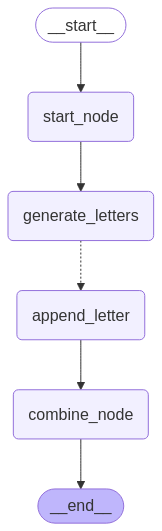

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

Come vediamo dall'immagine sembra un grafo lineare tuttavia non lo è dato che si generano un numero random di nodi che prendono lo stato da generate_letters e poi inviano con Send dei messaggi o stati al nodo append_letter.

Con Send() simuliamo i nodi dato che prendono uno sato e inviano uno stato a un'altro nodo.

In [17]:
initial_state = {"string_value": ""}
result = graph.invoke(initial_state)
print(result)

Generated letters: ['b', 'a', 'e', 'a', 'a', 'b', 'd', 'c', 'e']
Using letters from state: ['b', 'a', 'e', 'a', 'a', 'b', 'd', 'c', 'e']
Appending 'b'
Appending 'a'
Appending 'e'
Appending 'a'
Appending 'a'
Appending 'b'
Appending 'd'
Appending 'c'
Appending 'e'
combine_strings: Combined string_value='baeaabdce'
combine_strings: Final string_value='BAEAABDCE'
{'string_value': 'baeaabdceBAEAABDCE', 'letters': ['b', 'a', 'e', 'a', 'a', 'b', 'd', 'c', 'e']}
